In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)

def plot_iteration_metrics(checkpoint, iteration_to_plot=None):
    game_metrics = checkpoint.get('metrics')
    game_loss_metrics = checkpoint.get('game_loss_metrics')
    avg_loss_metrics = checkpoint.get('losses')
    eval_metrics = checkpoint.get('evaluation')

    if any(x is None for x in [game_metrics, game_loss_metrics, avg_loss_metrics, eval_metrics]):
        print("Missing required data in checkpoint.")
        return

    num_iterations = len(game_metrics)
    if iteration_to_plot is None:
        iteration_to_plot = num_iterations

    if iteration_to_plot < 1 or iteration_to_plot > num_iterations:
        print(f"Iteration {iteration_to_plot} out of range. Should be between 1 and {num_iterations}")
        return

    idx = iteration_to_plot - 1
    iteration_game_metrics = game_metrics[idx]
    iteration_loss_metrics = game_loss_metrics[idx]
    eval_result = eval_metrics[idx]

    games = np.arange(1, len(iteration_game_metrics) + 1)

    # Game lengths
    game_lengths = [m['game_length'] for m in iteration_game_metrics]

    # Outcomes
    outcomes = []
    for m in iteration_game_metrics:
        if m['is_draw']:
            outcomes.append(0)
        else:
            outcomes.append(1 if m['winner'] == 1 else -1)

    win_count = outcomes.count(1)
    loss_count = outcomes.count(-1)
    draw_count = outcomes.count(0)

    # Losses
    total_losses = [m['loss'] for m in iteration_loss_metrics]
    value_losses = [m['value_loss'] for m in iteration_loss_metrics]
    policy_losses = [m['policy_loss'] for m in iteration_loss_metrics]

    # Evaluation
    win_rate = eval_result.get('win_rate')
    draw_rate = eval_result.get('draw_rate')
    win_rate_random = eval_result.get('win_rate_random')
    draw_rate_random = eval_result.get('draw_rate_random')

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Game Lengths
    sns.lineplot(x=games, y=game_lengths, ax=axes[0, 0], marker='o', color=sns.color_palette()[0])
    axes[0, 0].set_title(f'Game Lengths (Iter {iteration_to_plot})')
    axes[0, 0].set_xlabel('Game Number')
    axes[0, 0].set_ylabel('Moves')

    # Outcomes (wins, losses, draws with better colors and order)
    sns.barplot(
        x=['Wins', 'Losses', 'Draws'],
        y=[win_count, loss_count, draw_count],
        ax=axes[0, 1],
        palette=['#2ca02c', '#1f77b4', '#7f7f7f']  # green, muted blue, gray
    )
    axes[0, 1].set_title(f'Outcomes (Iter {iteration_to_plot})')
    axes[0, 1].set_ylabel('Count')

    # Losses per game
    sns.lineplot(x=games, y=total_losses, label='Total Loss', ax=axes[1, 0], color=sns.color_palette()[0])
    sns.lineplot(x=games, y=value_losses, label='Value Loss', ax=axes[1, 0], color=sns.color_palette()[1])
    sns.lineplot(x=games, y=policy_losses, label='Policy Loss', ax=axes[1, 0], color=sns.color_palette()[2])
    axes[1, 0].set_title(f'Losses (Iter {iteration_to_plot})')
    axes[1, 0].set_xlabel('Game Number')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    # Evaluation
    eval_labels = ['Win vs Best', 'Draw vs Best', 'Win vs Rand', 'Draw vs Rand']
    eval_values = [win_rate, draw_rate, win_rate_random, draw_rate_random]
    sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')
    axes[1, 1].set_title(f'Evaluation Results (Iter {iteration_to_plot})')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_ylabel('Rate')
    for i, v in enumerate(eval_values):
        axes[1, 1].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_average_metrics(checkpoint):
    game_metrics = checkpoint.get('metrics')
    game_loss_metrics = checkpoint.get('game_loss_metrics')
    eval_metrics = checkpoint.get('evaluation')

    if any(x is None for x in [game_metrics, game_loss_metrics, eval_metrics]):
        print("Missing required data in checkpoint.")
        return

    sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    num_iters = len(game_metrics)
    max_games = max(len(m) for m in game_metrics)
    games = np.arange(1, max_games + 1)

    # --- 1. Game Lengths ---
    all_lengths = [[] for _ in range(max_games)]
    for metrics in game_metrics:
        for i, m in enumerate(metrics):
            all_lengths[i].append(m['game_length'])
    mean_lengths = [np.mean(x) if x else np.nan for x in all_lengths]
    min_lengths = [np.min(x) if x else np.nan for x in all_lengths]
    max_lengths = [np.max(x) if x else np.nan for x in all_lengths]
    ax = axes[0, 0]
    ax.plot(games, mean_lengths, label='Avg Game Length', color='blue')
    ax.fill_between(games, min_lengths, max_lengths, alpha=0.3, color='blue')
    ax.set_title('Avg Game Lengths')
    ax.set_xlabel('Game Number')
    ax.set_ylabel('Moves')

    # --- 2. Outcomes ---
    win_counts = []
    loss_counts = []
    draw_counts = []
    for metrics in game_metrics:
        outcomes = [0 if m['is_draw'] else (1 if m['winner'] == 1 else -1) for m in metrics]
        win_counts.append(outcomes.count(1))
        loss_counts.append(outcomes.count(-1))
        draw_counts.append(outcomes.count(0))
    def mean_min_max(arr): return np.mean(arr), np.min(arr), np.max(arr)
    win_mean, win_min, win_max = mean_min_max(win_counts)
    loss_mean, loss_min, loss_max = mean_min_max(loss_counts)
    draw_mean, draw_min, draw_max = mean_min_max(draw_counts)
    bars = ['Wins', 'Losses', 'Draws']
    means = [win_mean, loss_mean, draw_mean]
    lowers = [win_mean - win_min, loss_mean - loss_min, draw_mean - draw_min]
    uppers = [win_max - win_mean, loss_max - loss_mean, draw_max - draw_mean]
    ax = axes[0, 1]
    ax.bar(bars, means, yerr=[lowers, uppers], capsize=5, color=['#4daf4a', '#377eb8', '#999999'])
    ax.set_title('Avg Outcomes Across Iterations')
    ax.set_ylabel('Count')

    # --- 3. Evaluation ---
    eval_keys = ['win_rate', 'draw_rate', 'win_rate_random', 'draw_rate_random']
    eval_labels = ['Win vs Best', 'Draw vs Best', 'Win vs Rand', 'Draw vs Rand']
    eval_data = {k: [] for k in eval_keys}
    for eval_iter in eval_metrics:
        for k in eval_keys:
            eval_data[k].append(eval_iter.get(k, 0.0))
    eval_means = [np.mean(eval_data[k]) for k in eval_keys]
    eval_lowers = [np.mean(eval_data[k]) - np.min(eval_data[k]) for k in eval_keys]
    eval_uppers = [np.max(eval_data[k]) - np.mean(eval_data[k]) for k in eval_keys]
    ax = axes[0, 2]
    ax.bar(eval_labels, eval_means, yerr=[eval_lowers, eval_uppers], capsize=5, color=['#2ca02c', '#8c564b', '#1f77b4', '#7f7f7f'])
    ax.set_ylim(0, 1)
    ax.set_title('Avg Evaluation Results')
    ax.set_ylabel('Rate')

    # --- 4–6. Losses ---
    all_total_losses = [[] for _ in range(max_games)]
    all_value_losses = [[] for _ in range(max_games)]
    all_policy_losses = [[] for _ in range(max_games)]
    for iter_loss_metrics in game_loss_metrics:
        for i, m in enumerate(iter_loss_metrics):
            all_total_losses[i].append(m['loss'])
            all_value_losses[i].append(m['value_loss'])
            all_policy_losses[i].append(m['policy_loss'])

    def plot_loss(ax, data, label, color):
        means = [np.mean(x) if x else np.nan for x in data]
        mins = [np.min(x) if x else np.nan for x in data]
        maxs = [np.max(x) if x else np.nan for x in data]
        ax.plot(games, means, label=label, color=color)
        ax.fill_between(games, mins, maxs, alpha=0.3, color=color)
        ax.set_title(f'Avg {label}')
        ax.set_xlabel('Game Number')
        ax.set_ylabel('Loss')

    plot_loss(axes[1, 0], all_total_losses, 'Total Loss', 'red')
    plot_loss(axes[1, 1], all_value_losses, 'Value Loss', 'blue')
    plot_loss(axes[1, 2], all_policy_losses, 'Policy Loss', 'green')

    plt.tight_layout()
    plt.show()



In [3]:
checkpoint = torch.load("weights/checkpoint_iter_10.pth", map_location='cpu')

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\2484574215.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("weights_final/checkpoint_iter_1

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


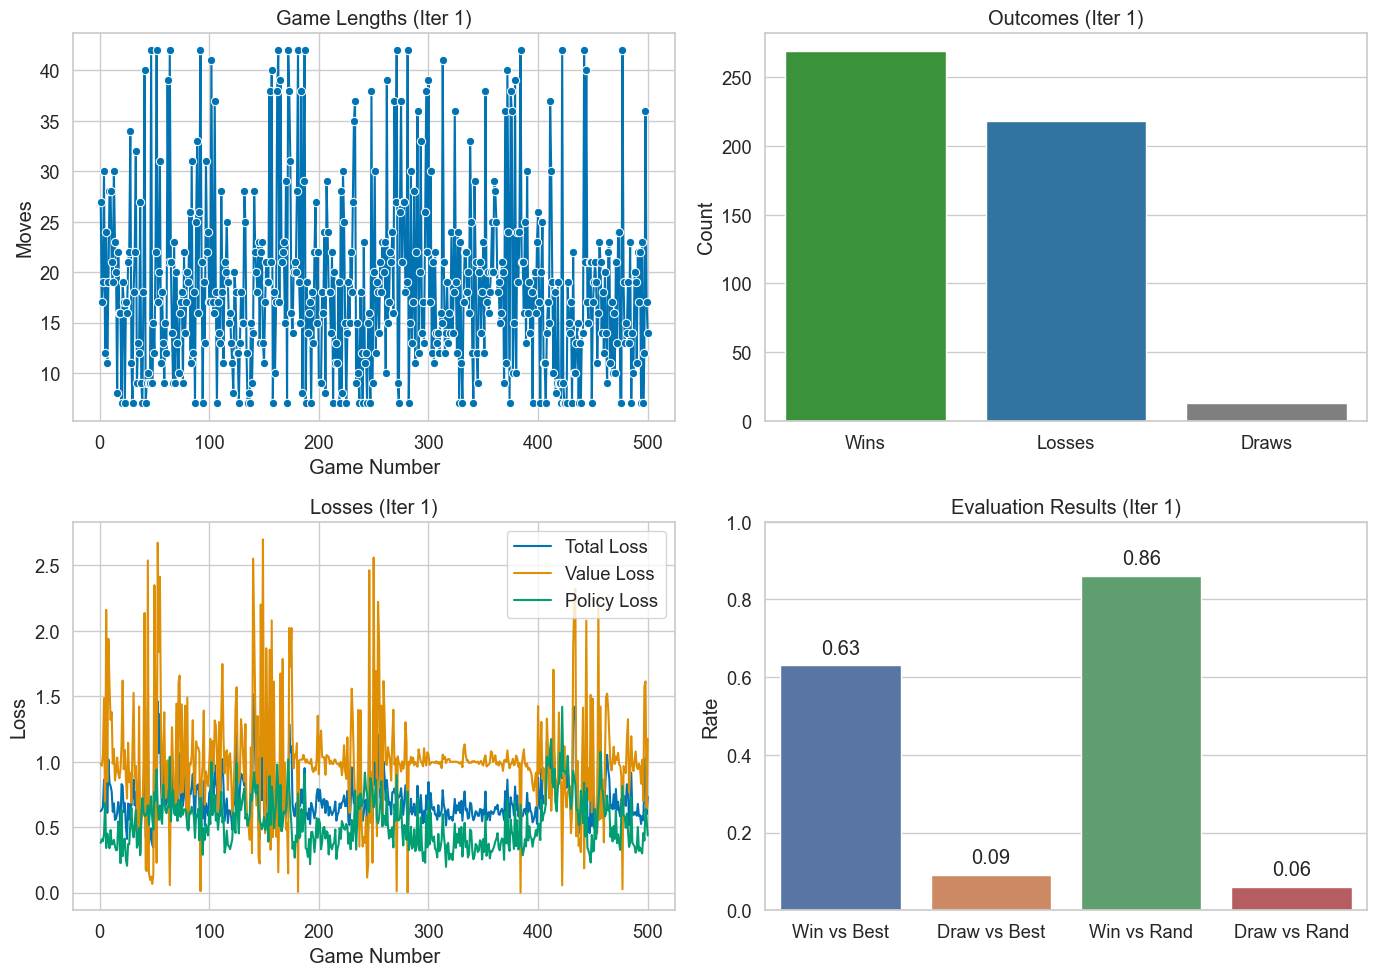

In [4]:
plot_iteration_metrics(checkpoint, iteration_to_plot=1)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


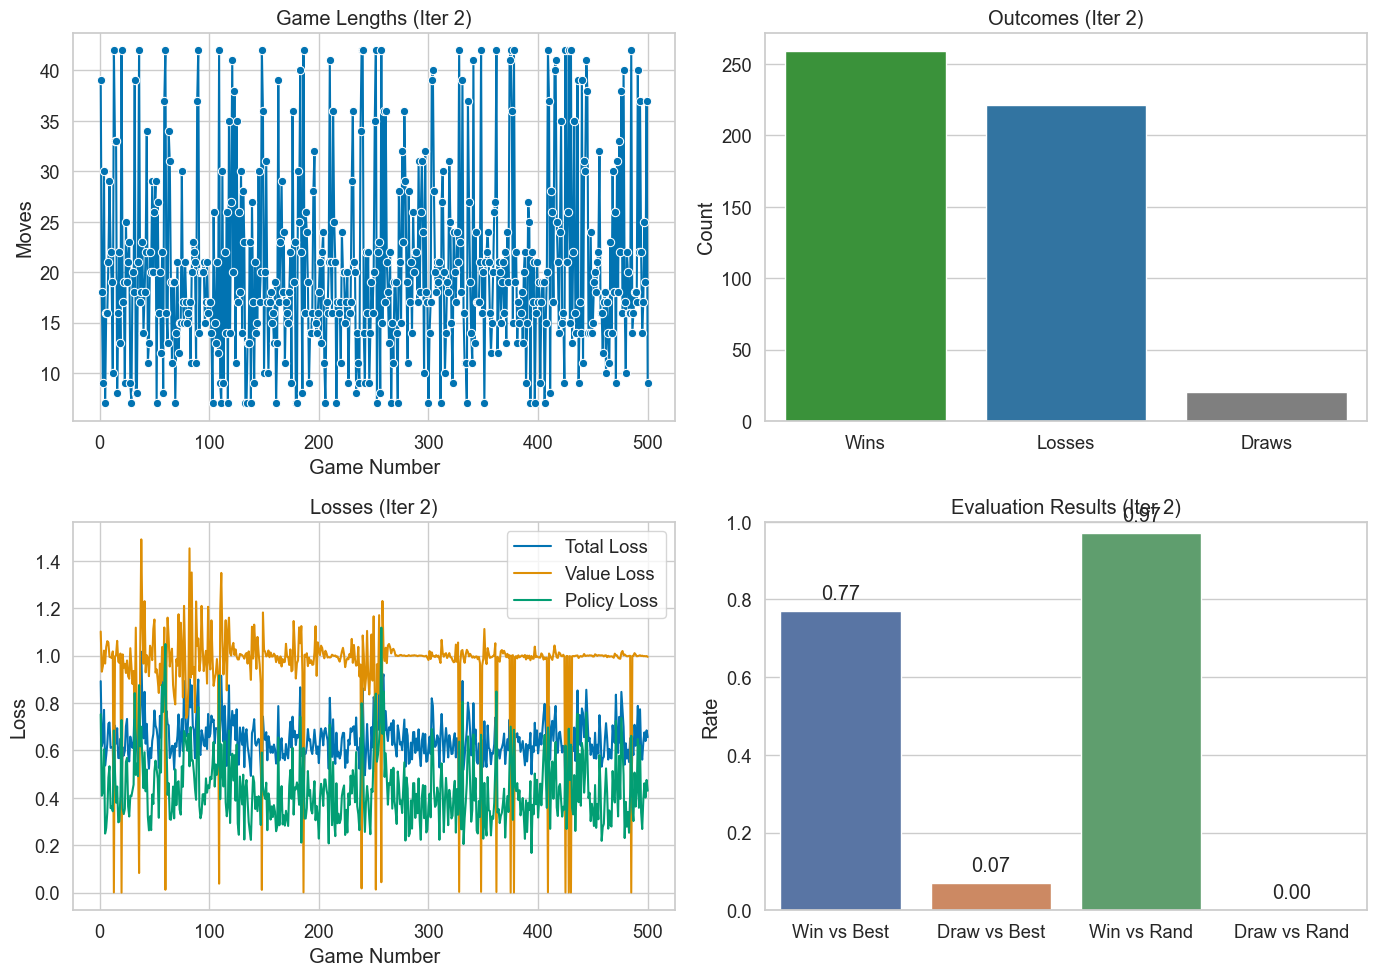

In [5]:
plot_iteration_metrics(checkpoint, iteration_to_plot=2)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


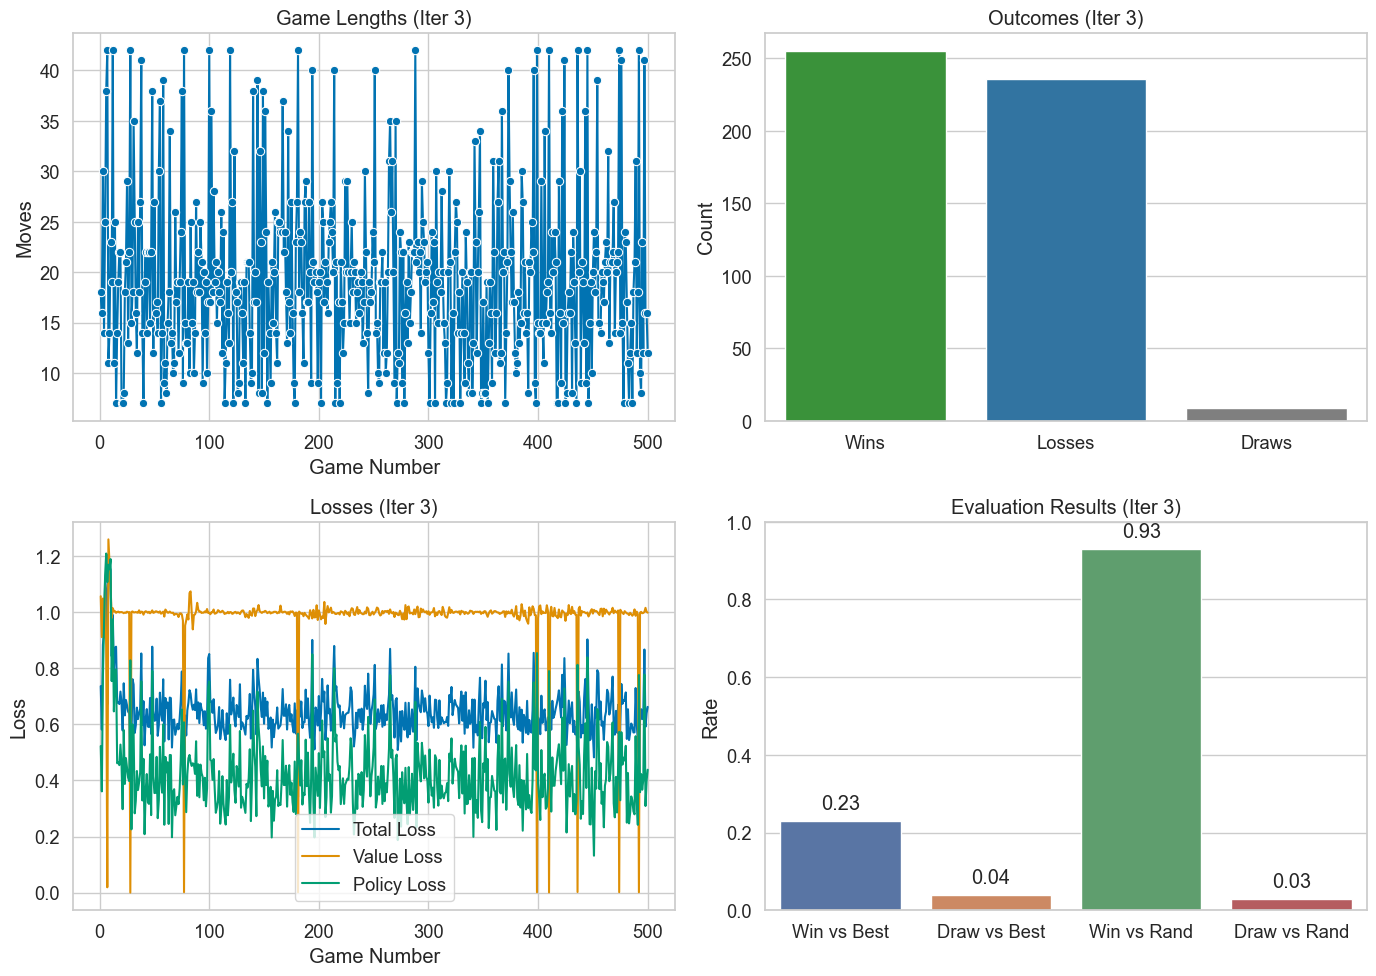

In [6]:
plot_iteration_metrics(checkpoint, iteration_to_plot=3)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


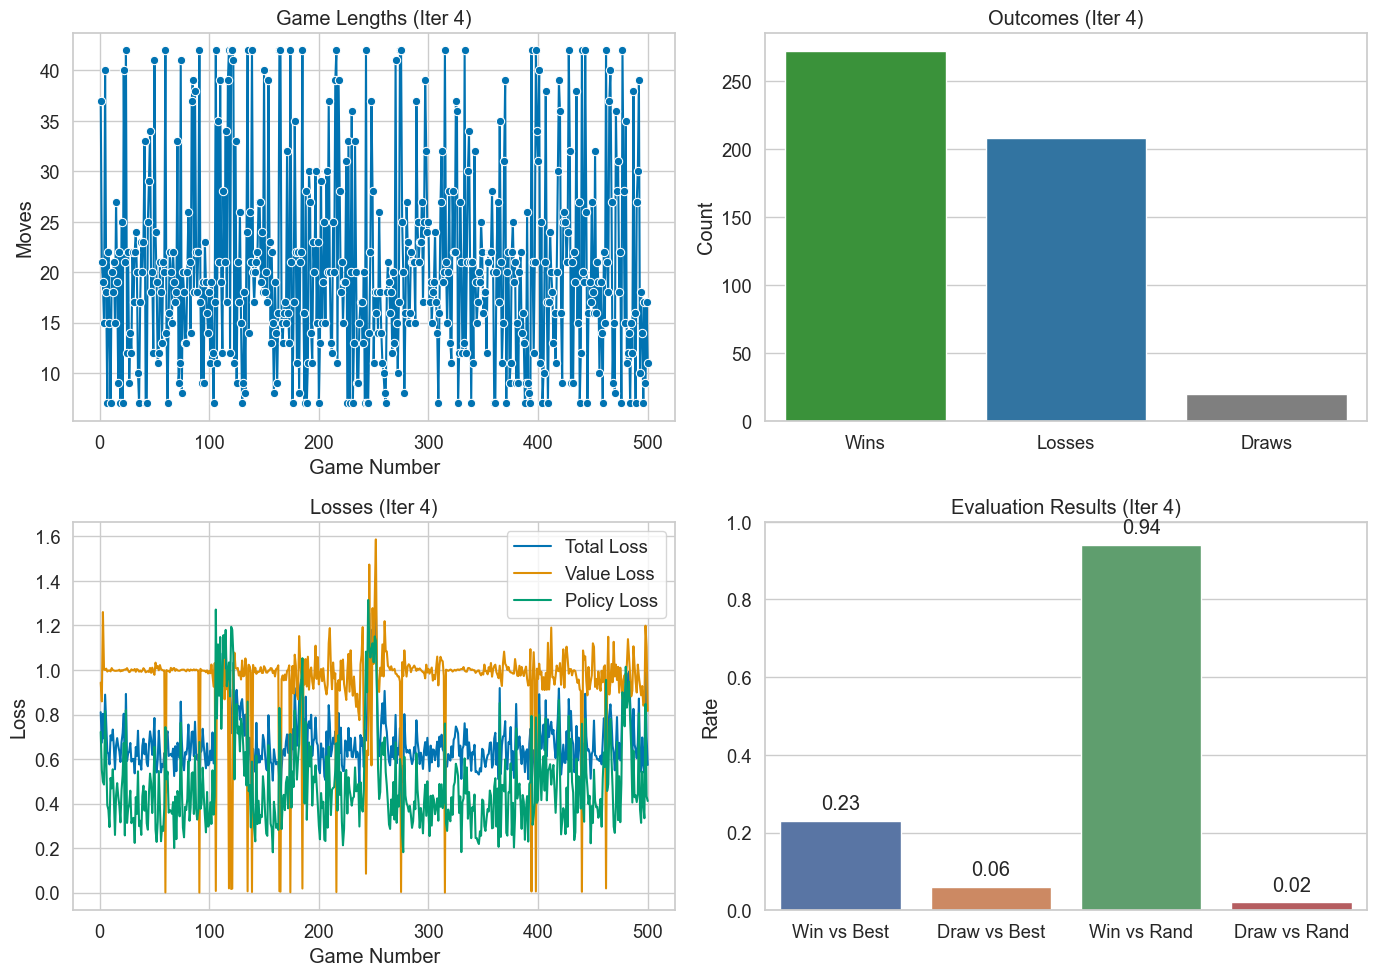

In [7]:
plot_iteration_metrics(checkpoint, iteration_to_plot=4)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


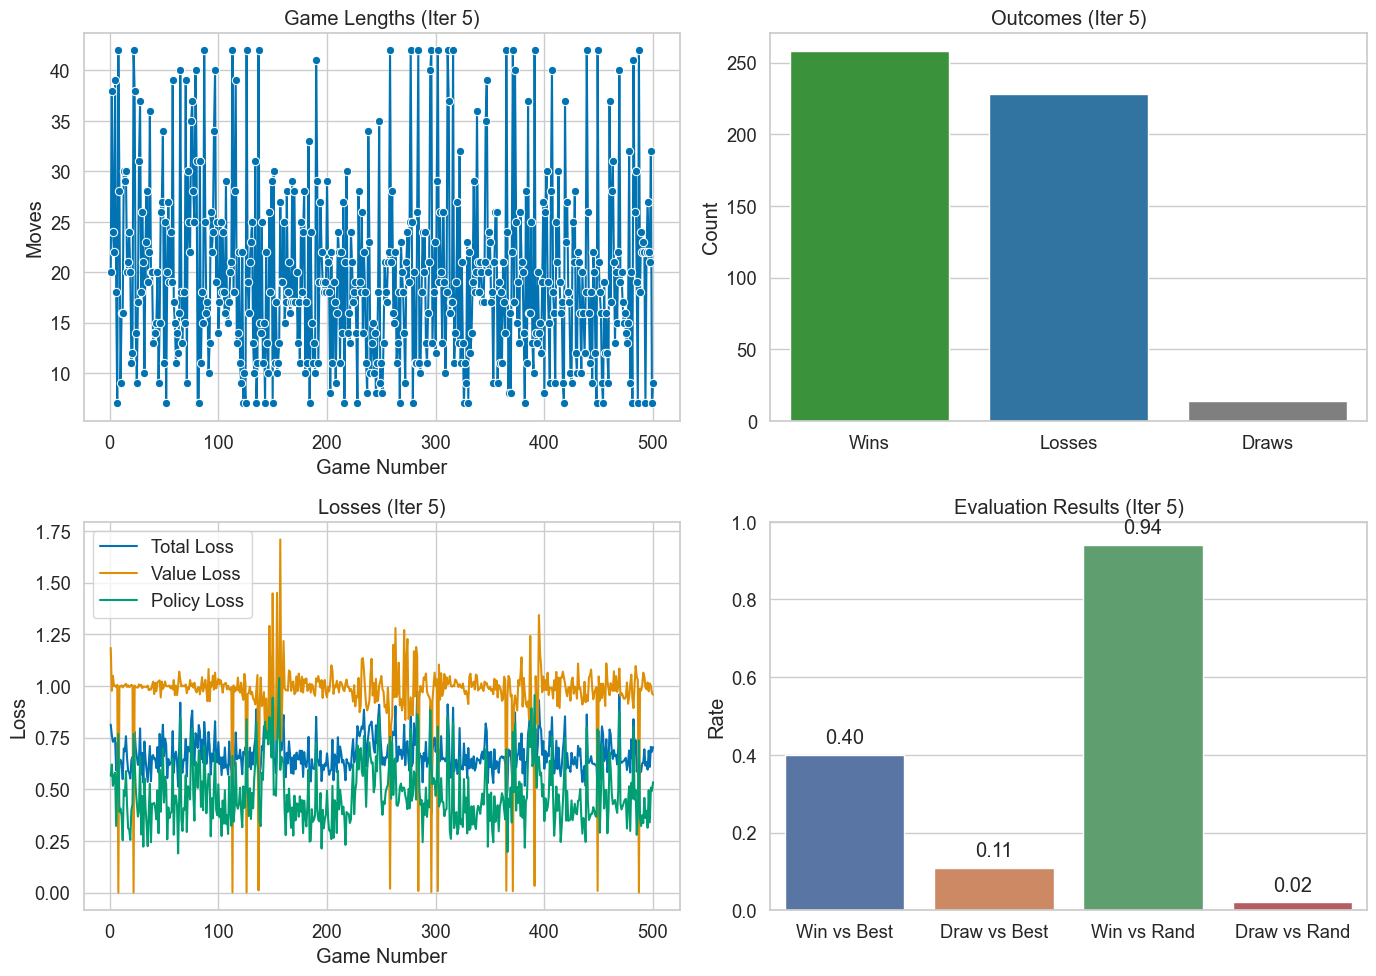

In [8]:
plot_iteration_metrics(checkpoint, iteration_to_plot=5)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


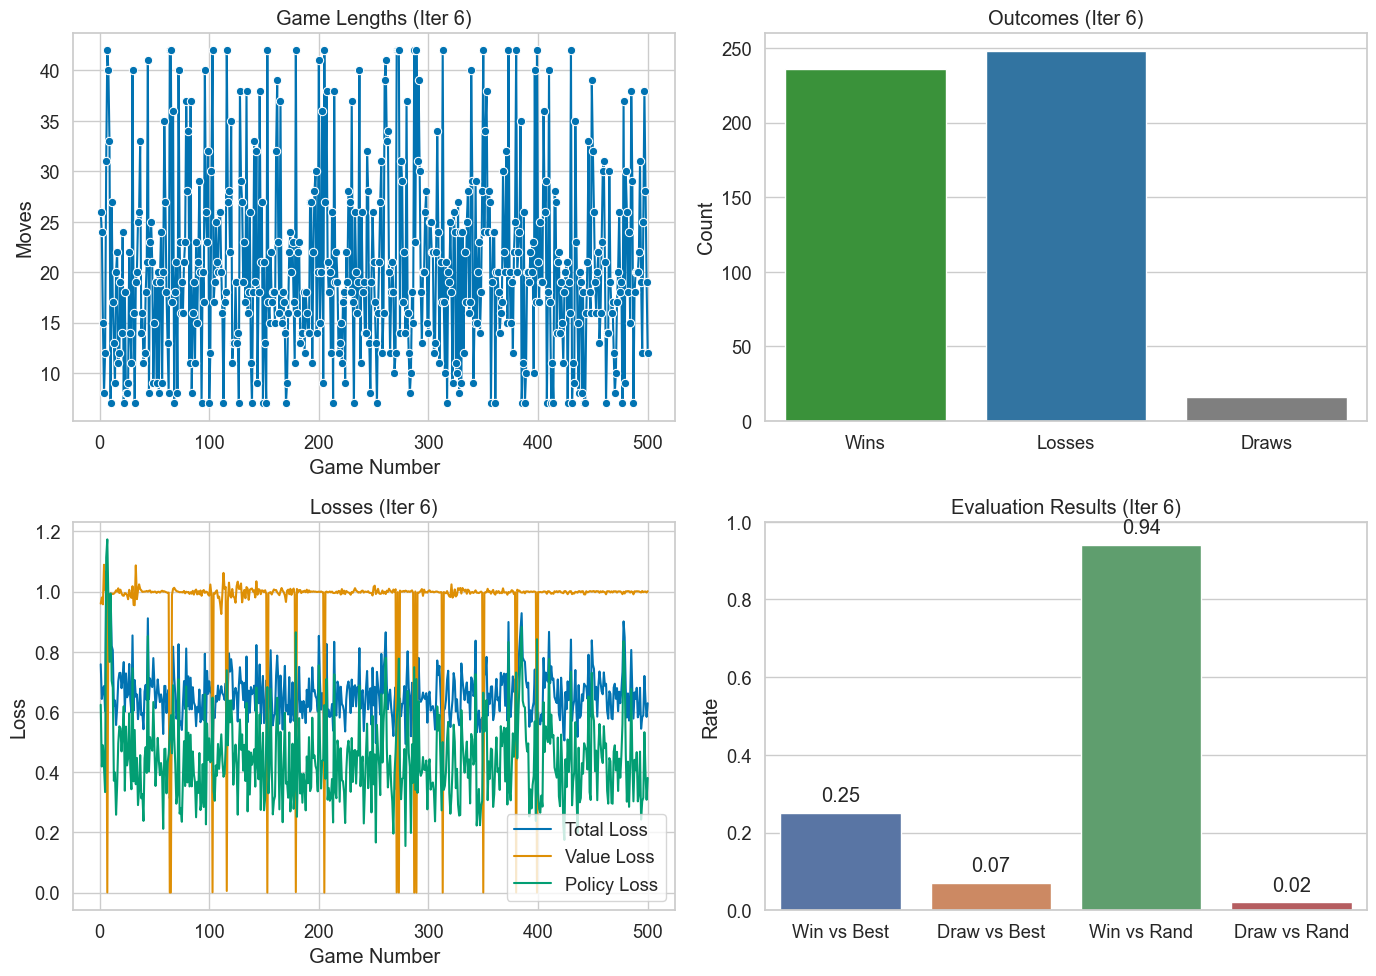

In [9]:
plot_iteration_metrics(checkpoint, iteration_to_plot=6)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


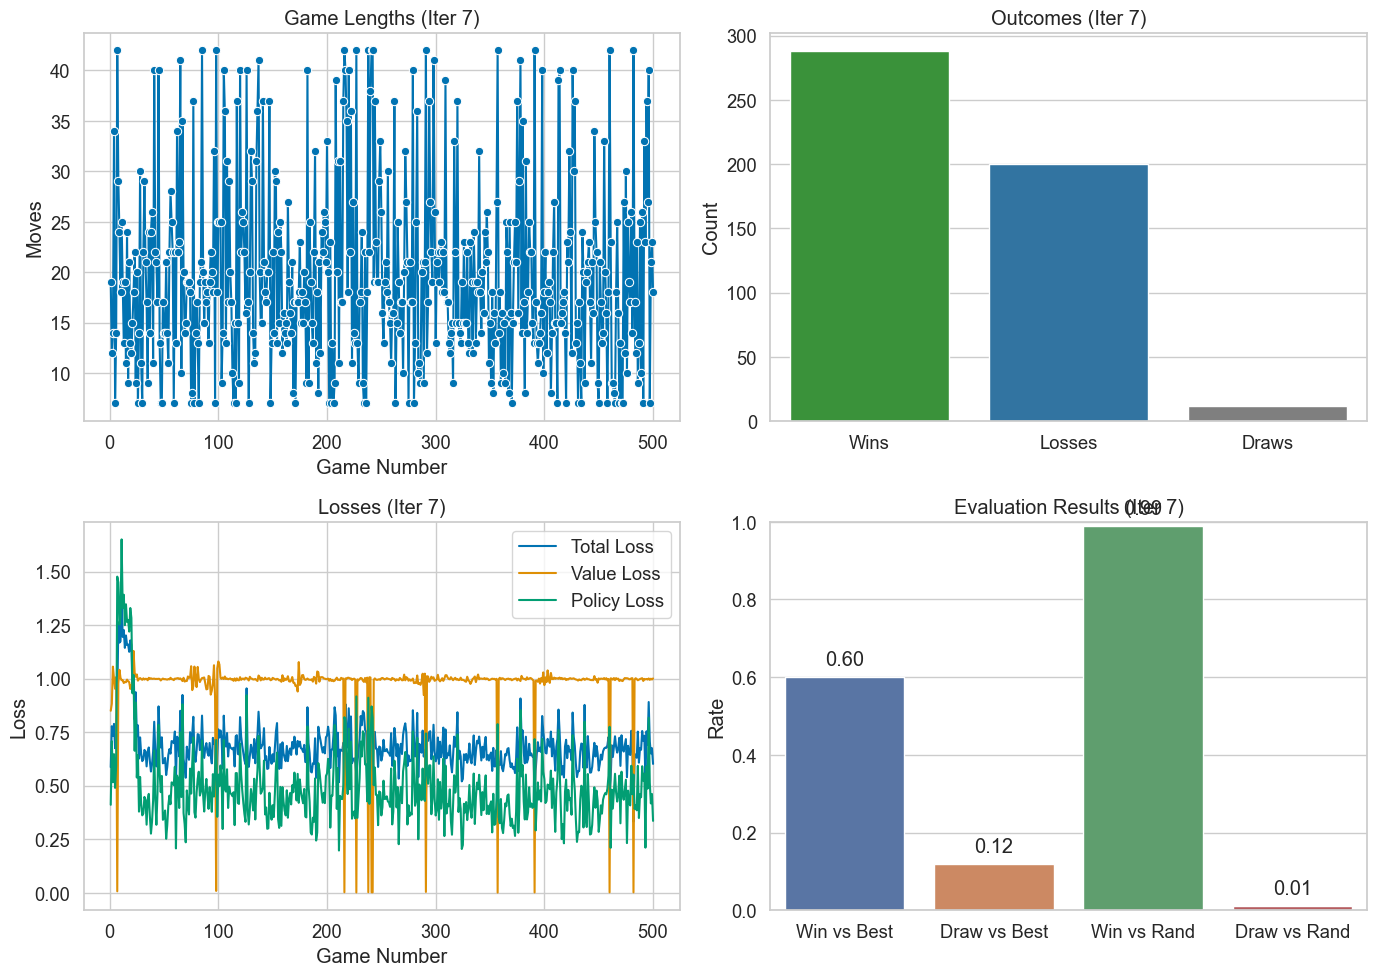

In [10]:
plot_iteration_metrics(checkpoint, iteration_to_plot=7)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


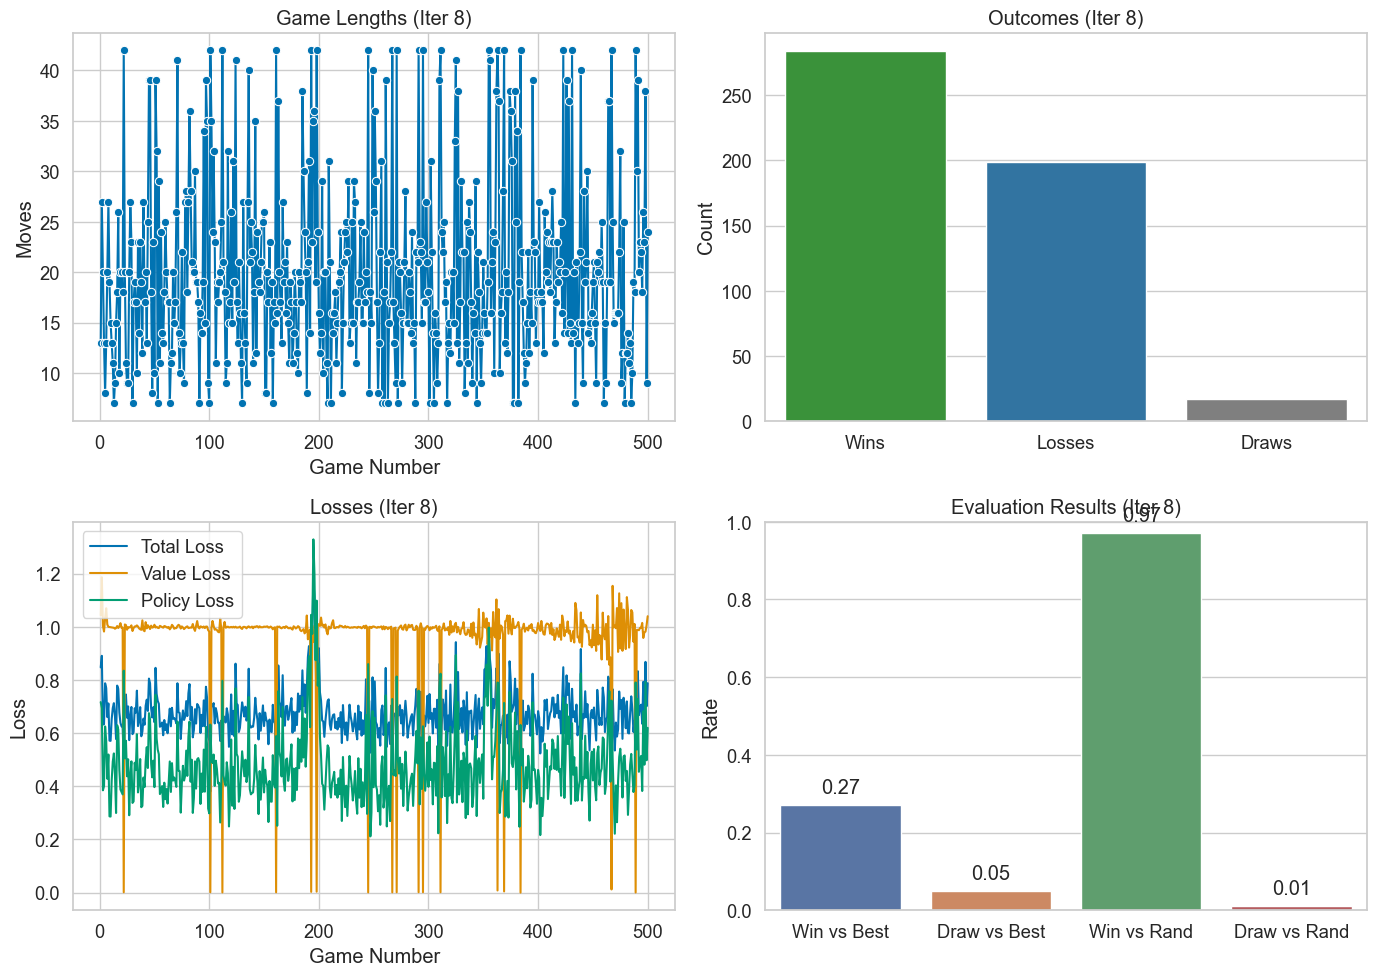

In [11]:
plot_iteration_metrics(checkpoint, iteration_to_plot=8)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


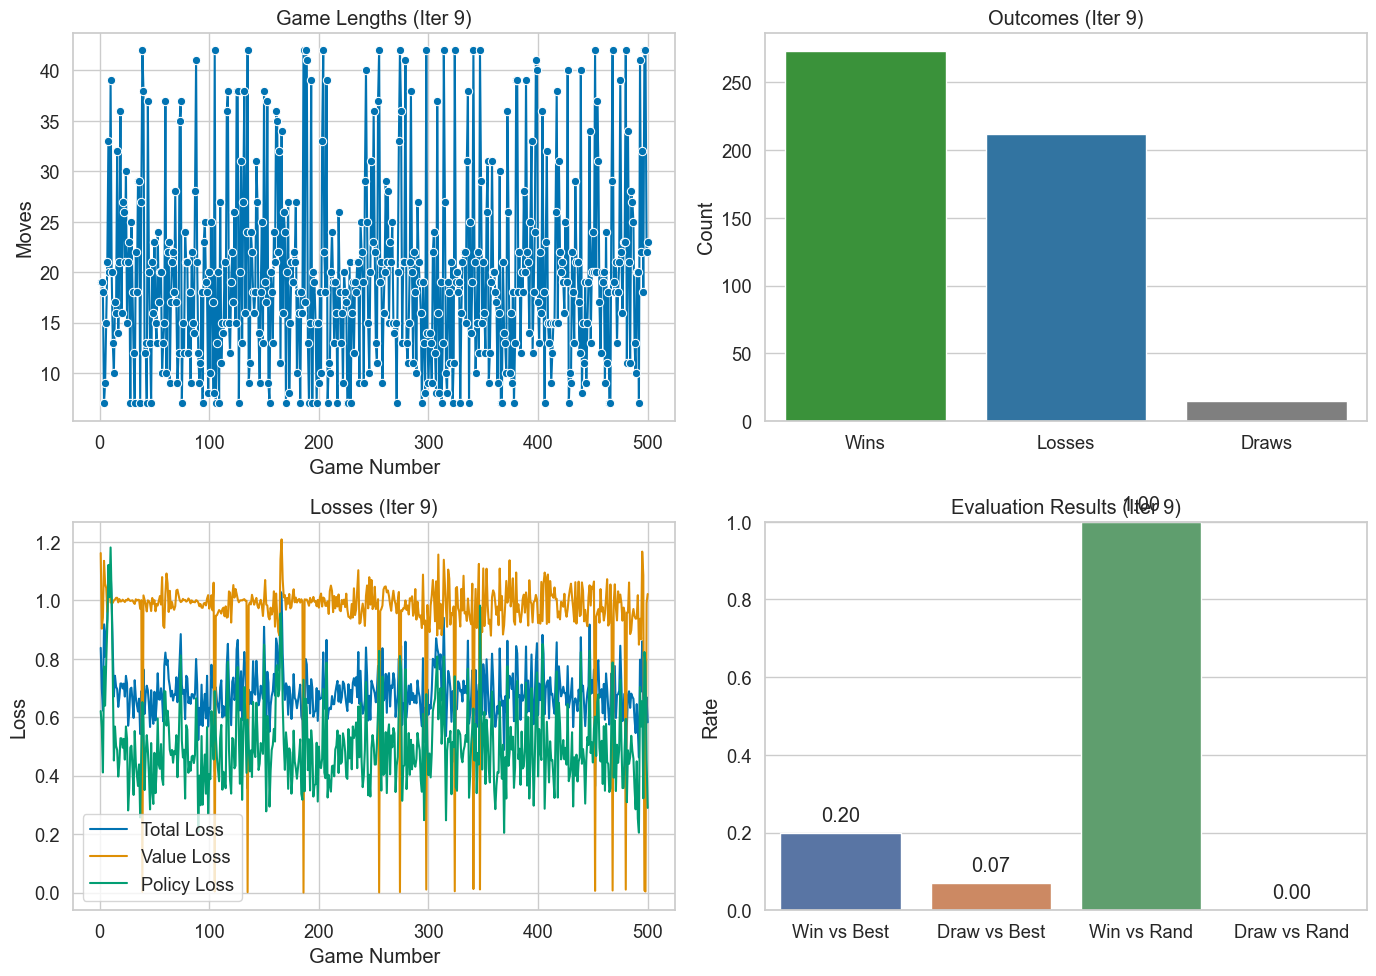

In [12]:
plot_iteration_metrics(checkpoint, iteration_to_plot=9)

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\4253581291.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eval_labels, y=eval_values, ax=axes[1, 1], palette='deep')


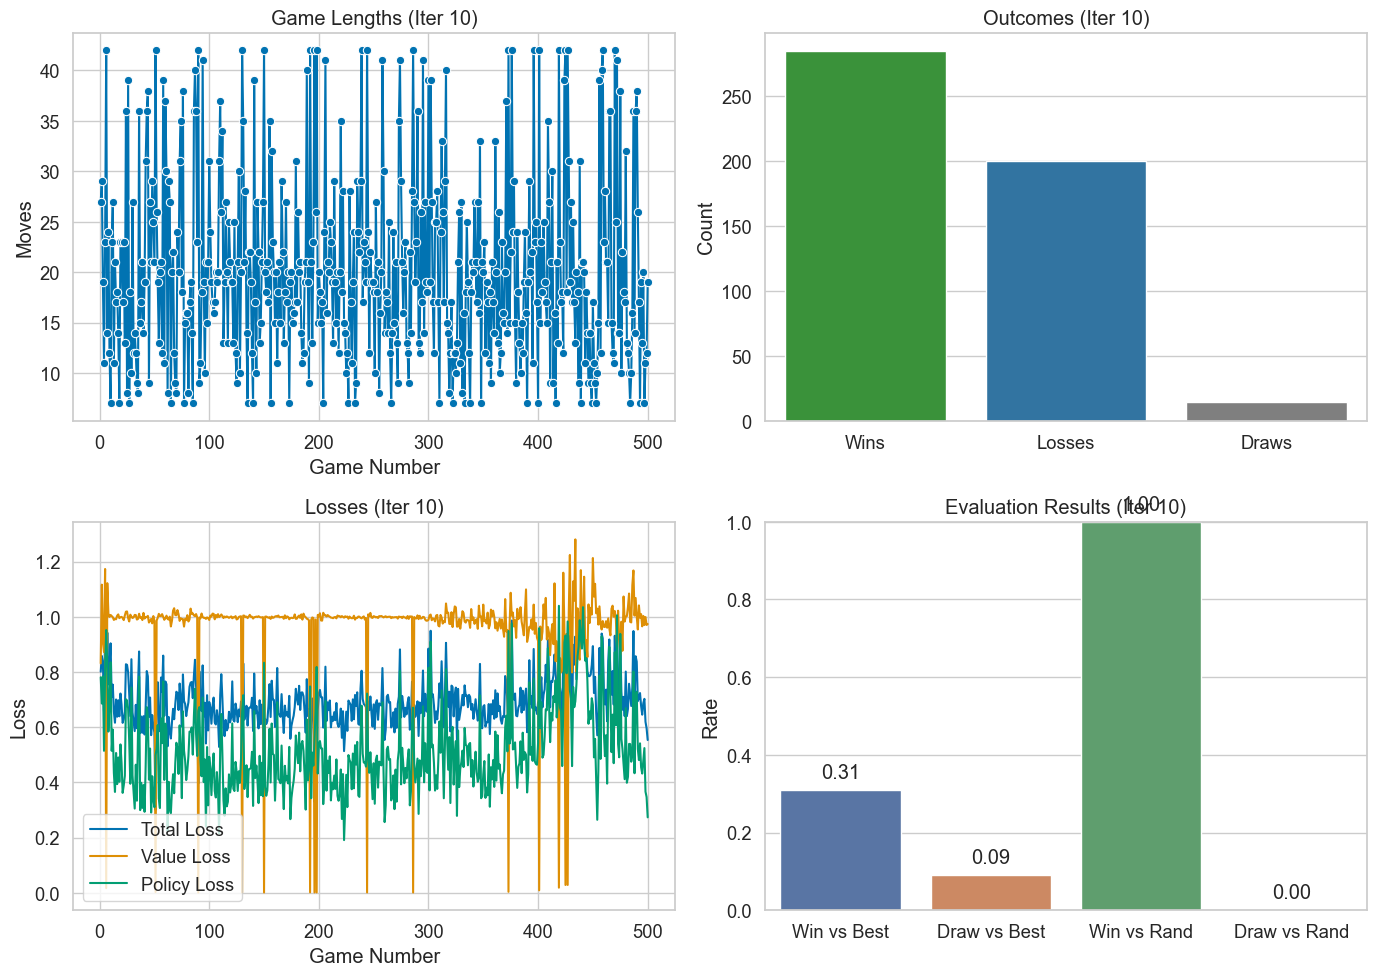

In [13]:
plot_iteration_metrics(checkpoint, iteration_to_plot=10)

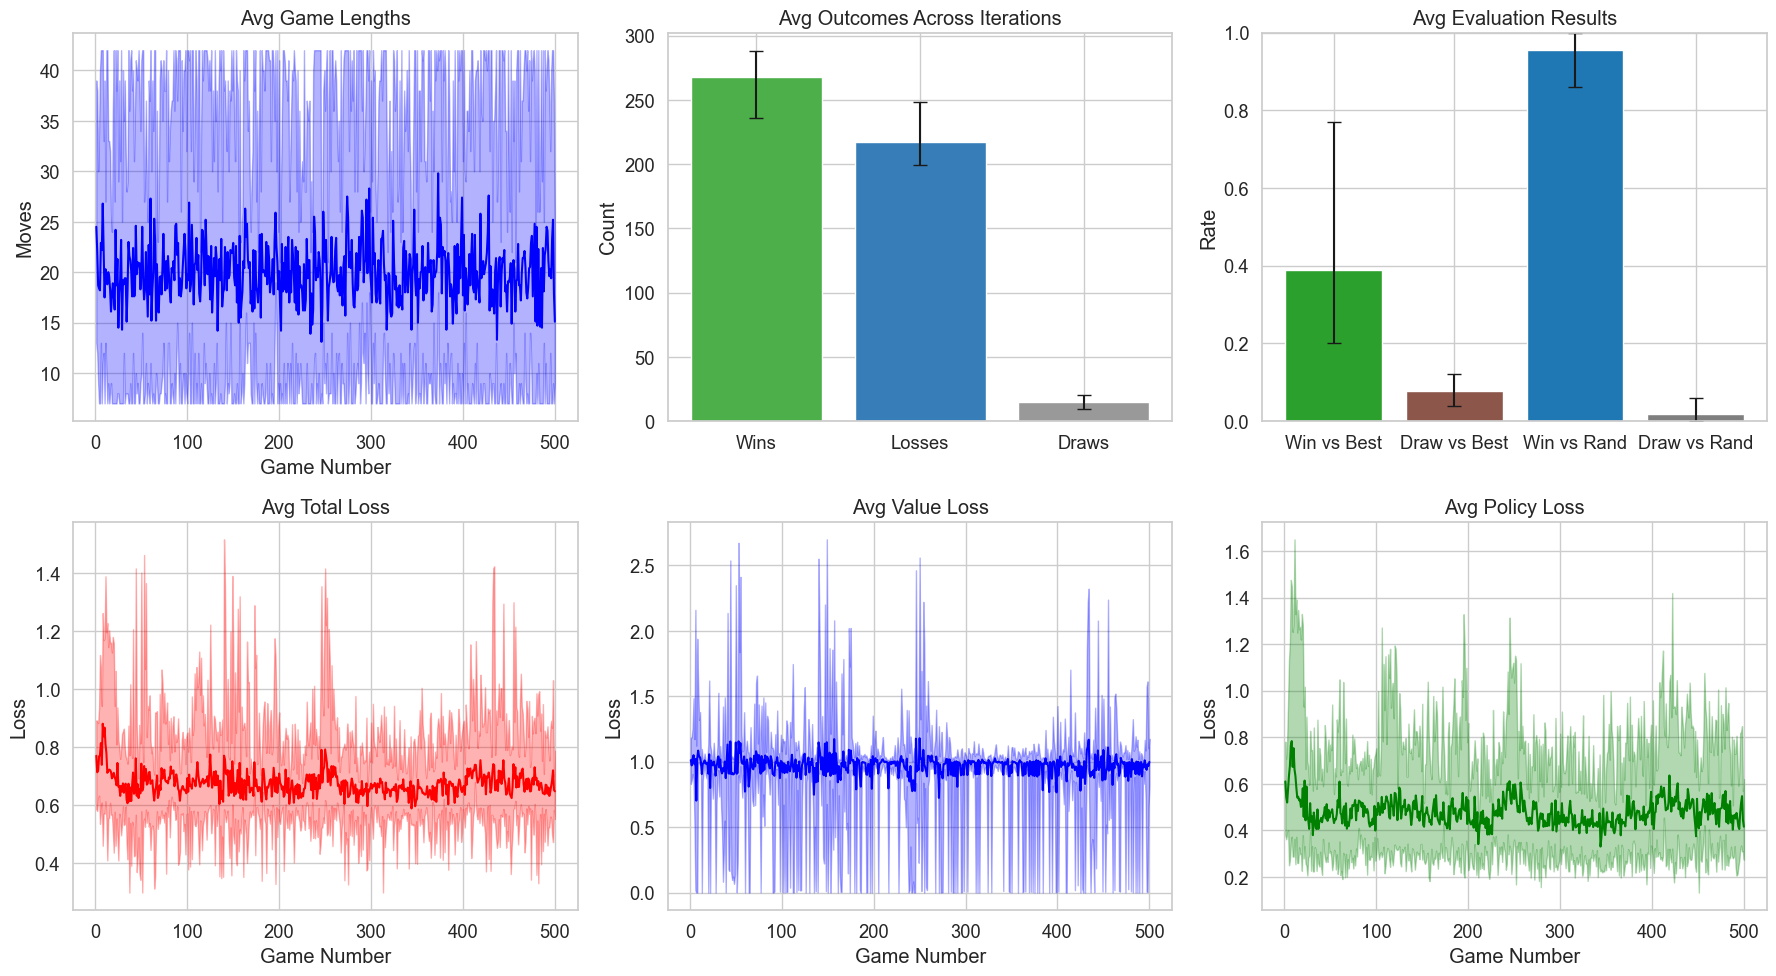

In [18]:
plot_average_metrics(checkpoint)

In [29]:
checkpoint = torch.load("weights/alphazero_connect4_final.pth", map_location='cpu')

C:\Users\Neurojedi\AppData\Local\Temp\ipykernel_28136\3485794093.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("weights_final/alphazero_connect

In [31]:
print("Keys in checkpoint:", checkpoint.keys())

Keys in checkpoint: odict_keys(['initial_conv.weight', 'initial_conv.bias', 'initial_bn.weight', 'initial_bn.bias', 'initial_bn.running_mean', 'initial_bn.running_var', 'initial_bn.num_batches_tracked', 'res1_conv1.weight', 'res1_bn1.weight', 'res1_bn1.bias', 'res1_bn1.running_mean', 'res1_bn1.running_var', 'res1_bn1.num_batches_tracked', 'res1_conv2.weight', 'res1_bn2.weight', 'res1_bn2.bias', 'res1_bn2.running_mean', 'res1_bn2.running_var', 'res1_bn2.num_batches_tracked', 'res2_conv1.weight', 'res2_bn1.weight', 'res2_bn1.bias', 'res2_bn1.running_mean', 'res2_bn1.running_var', 'res2_bn1.num_batches_tracked', 'res2_conv2.weight', 'res2_bn2.weight', 'res2_bn2.bias', 'res2_bn2.running_mean', 'res2_bn2.running_var', 'res2_bn2.num_batches_tracked', 'res3_conv1.weight', 'res3_bn1.weight', 'res3_bn1.bias', 'res3_bn1.running_mean', 'res3_bn1.running_var', 'res3_bn1.num_batches_tracked', 'res3_conv2.weight', 'res3_bn2.weight', 'res3_bn2.bias', 'res3_bn2.running_mean', 'res3_bn2.running_var', '